Считал все файлы


In [11]:
import os
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загрузка стоп-слов
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def load_and_preprocess_documents(folder_path):
    # Чтение всех txt файлов в папке
    file_paths = glob.glob(os.path.join(folder_path, "*.txt"))
    documents = []
    
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            # Базовая предобработка: удаление спецсимволов, токенизация, удаление стоп-слов
            text = re.sub(r'\W', ' ', text)  # Удаление спецсимволов
            words = word_tokenize(text.lower())  # Токенизация и приведение к нижнему регистру
            words = [word for word in words if word not in stop_words]  # Удаление стоп-слов
            documents.append(' '.join(words))  # Преобразование обратно в текст
    
    return documents

folder_path = r'C:\Users\artem\Downloads\sampled_texts\sampled_texts'
documents = load_and_preprocess_documents(folder_path)
print(f"Прочитано {len(documents)} документов.")


Прочитано 200 документов.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Преобразовал каждый документ в вектор

In [12]:
from sentence_transformers import SentenceTransformer

# Загрузка предобученной модели для создания эмбеддингов
model = SentenceTransformer('all-MiniLM-L6-v2')

# Преобразование каждого документа в вектор (эмбеддинг)
embeddings = model.encode(documents)

print(f"Эмбеддинги документов успешно получены. Размер эмбеддингов: {embeddings.shape}")


2024-10-14 21:32:21,064 - INFO - Use pytorch device_name: cpu
2024-10-14 21:32:21,065 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 7/7 [00:00<00:00,  8.64it/s]

Эмбеддинги документов успешно получены. Размер эмбеддингов: (200, 384)


С помощью kmeans провел кластаризацию эмбедингов и получил методом локтя, что количество кластеров равна 4. 
В коде, после построения графика методом локтя, предлагается выбрать 4 кластера. Это означает, 
что на графике заметен «изгиб» на отметке 4 кластеров, после чего добавление большего числа кластеров не приводит к значительному улучшению инерции.

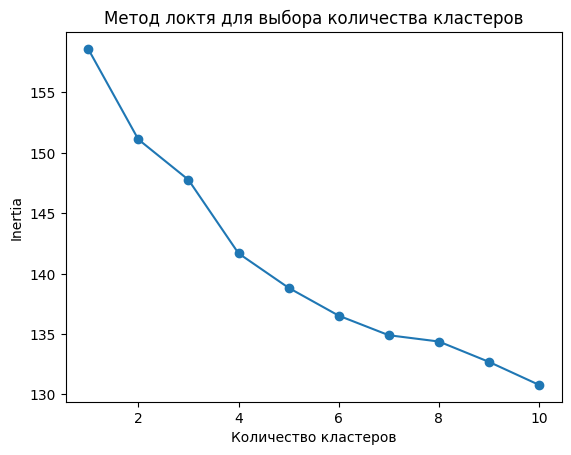

Документы распределены по кластерам: [3 2 3 3 1 2 3 0 3 3 2 0 0 3 3 3 3 0 3 2 1 0 3 2 3 3 3 3 3 2 2 0 1 2 0 1 3
 3 3 0 0 1 1 2 2 1 1 0 0 3 1 0 2 0 2 3 3 1 3 2 2 1 0 0 0 3 1 0 3 0 0 3 1 3
 0 2 3 0 3 0 1 2 3 3 3 2 1 3 3 2 1 0 1 0 1 0 0 1 1 2 3 3 2 0 2 0 3 2 0 3 1
 3 0 0 3 0 1 3 1 1 3 3 2 0 0 1 0 3 3 2 3 0 1 1 1 1 3 1 2 3 2 1 1 3 2 1 2 2
 0 3 3 1 2 1 2 3 1 3 3 2 0 0 2 0 0 0 1 3 1 2 3 2 2 0 0 3 3 3 1 3 0 3 3 3 0
 3 0 0 1 3 0 1 0 3 3 3 1 0 0 3]


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Выбор оптимального количества кластеров с помощью метода локтя
def find_optimal_clusters(embeddings, max_k):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.title('Метод локтя для выбора количества кластеров')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.show()

find_optimal_clusters(embeddings, max_k=10)

# После определения оптимального числа кластеров (допустим, 3):
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(embeddings)

# Присваивание кластеров каждому документу
clusters = kmeans.labels_
print(f"Документы распределены по кластерам: {clusters}")


С помощью knn и перебора гиперпараметров, выяснили, что мой пример относится к 3 кластеру

In [25]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
import numpy as np
import logging

# Нормализуем эмбеддинги перед использованием в модели NearestNeighbors
embeddings_normalized = normalize(embeddings)
# Пользовательская метрика для оценки качества NearestNeighbors
def custom_knn_scorer(estimator, X):
    # Оцениваем среднее расстояние до ближайшего соседа
    distances, _ = estimator.kneighbors(X)
    return -np.mean(distances)  # Используем отрицательное значение, чтобы сделать метрику минимизируемой

# Функция классификации нового документа с оптимизацией параметров через GridSearch
def classify_new_document_with_improvements(new_document_path, model, embeddings_normalized, clusters):
    # Чтение и предобработка нового документа
    with open(new_document_path, 'r', encoding='utf-8') as file:
        new_document = file.read()

    # Генерация и нормализация эмбеддинга для нового документа
    new_document_embedding = model.encode([new_document])
    new_document_embedding_normalized = normalize(new_document_embedding)

    # Определение гиперпараметров для поиска через GridSearchCV
    param_grid_nn = {
        'n_neighbors': [1, 3, 5],  # Количество соседей для поиска
        'metric': ['cosine', 'euclidean', 'manhattan']  # Метрики расстояния
    }

    # Инициализация NearestNeighbors
    nn = NearestNeighbors()

    # Настройка GridSearchCV для подбора гиперпараметров с пользовательской метрикой
    grid_search_nn = GridSearchCV(nn, param_grid_nn, scoring=custom_knn_scorer, cv=3, verbose=1)
    grid_search_nn.fit(embeddings_normalized)

    # Лучший NearestNeighbors после подбора параметров
    best_nn = grid_search_nn.best_estimator_
    logging.info(f"Лучшие параметры NearestNeighbors: {grid_search_nn.best_params_}")

    # Использование лучшей модели для поиска ближайшего кластера
    distance, indices = best_nn.kneighbors(new_document_embedding_normalized)

    # Рассмотрим несколько ближайших соседей для классификации
    nearest_clusters = clusters[indices[0]]
    
    # Применяем голосование по ближайшим кластерам
    nearest_cluster = np.bincount(nearest_clusters).argmax()

    logging.info(f"Новый документ отнесен к кластеру: {nearest_cluster}")
    return int(nearest_cluster)

# Пример использования
new_document_path = r'C:\Users\artem\Downloads\new_documents.txt'
classify_new_document_with_improvements(new_document_path, model, embeddings_normalized, clusters)


Batches: 100%|██████████| 1/1 [00:00<00:00, 55.66it/s]
2024-10-14 22:04:52,580 - INFO - Лучшие параметры NearestNeighbors: {'metric': 'cosine', 'n_neighbors': 1}
2024-10-14 22:04:52,582 - INFO - Новый документ отнесен к кластеру: 3


Fitting 3 folds for each of 9 candidates, totalling 27 fits


3